In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score,train_test_split,cross_validate, StratifiedKFold
from sklearn.utils  import shuffle
import joblib
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
%matplotlib inline
import os
from collections import Counter
#Required RDKit modules(部分可能用不到),
import rdkit as rd
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import RDConfig
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.AtomPairs import Pairs, Torsions
import sklearn as sk
from sklearn import metrics
import joblib
from sklearn.utils import shuffle 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc,roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score,train_test_split,cross_validate, StratifiedKFold
# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore") 
import matplotlib.pyplot as plt
from rdkit import Chem

In [2]:
pwd

'/home/md06/public/jupytercode/kxy/ADK-568/分子指纹/4-模型解释/GBDT-ECFPs'

In [3]:
from matplotlib import font_manager, pyplot as plt

# 查找系统中所有可用的Times New Roman字体的路径
times_new_roman = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
# 从列表中找到一个指定的字体名称，并确保字体能支持加粗
t_nr_path = [f for f in times_new_roman if 'Times New Roman' in f and 'Bold' in f]

if t_nr_path:
    # 如果找到了Times New Roman Bold字体，设置为默认字体
    prop = font_manager.FontProperties(fname=t_nr_path[0])
    plt.rcParams['font.family'] = prop.get_name()
    plt.rcParams['font.weight'] = 'bold'  # 设置字体为加粗
else:
    # 如果没有找到加粗的Times New Roman，尝试设置为普通的Times New Roman并加粗
    t_nr_path = [f for f in times_new_roman if 'Times New Roman' in f]
    if t_nr_path:
        prop = font_manager.FontProperties(fname=t_nr_path[0])
        plt.rcParams['font.family'] = prop.get_name()
        plt.rcParams['font.weight'] = 'bold'
    else:
        # 如果没有找到Times New Roman，使用默认的衬线字体并设置为加粗
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.weight'] = 'bold'

In [4]:
data = pd.read_csv('./train-dataset-ECFPs.csv')
data2 = pd.read_csv('./test-dataset-ECFPs.csv')
#x_mor = data.iloc[:,1:]
#y = data["type"]
#x_mor_train, x_mor_test, y_mor_train, y_mor_test = train_test_split(x_mor, y, test_size=0.2, stratify=y, 
                                                                   # random_state=13)
x_mor_train = data.iloc[:,2:]   #第三列以后的数据，Python中索引是从0开始的
y_mor_train = data.iloc[:,1:2]  #左开右闭，读取第二列的数据
x_mor_test = data2.iloc[:,2:]
y_mor_test = data2.iloc[:,1:2]

In [5]:
X = x_mor_train    #x_mor_train 是输入特征，
Y = y_mor_train    #y_mor_train 是对应的目标变量（即标签）。
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)    
#K折交叉验证（Stratified K-Fold Cross Validation）
#shuffle=True 表示在每次分割前都会对数据进行随机洗牌
#random_state=0 是设置随机种子，确保结果的可重复性

In [6]:
train_X = x_mor_train
train_Y = y_mor_train
test_X = x_mor_test
test_Y = y_mor_test

## RF随机森林

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(random_state=0,
                            class_weight = 'balanced',
                            criterion = 'entropy',
                            max_features = 'sqrt',
                            bootstrap = True,
                            max_depth = 20,
                            min_samples_leaf = 3,
                            min_samples_split = 7,
                            n_estimators = 32,
                            oob_score = True
                           )
estimator = RF
estimator.fit(train_X, train_Y)

## XGBoost

In [ ]:
from xgboost.sklearn import XGBClassifier
xgb = XGBClassifier(
    random_state=0,
    objective='binary:logistic',
    colsample_bytree = 0.7,
    gamma = 0.7,
    max_depth = 3,
    min_child_weight = 1,
    n_estimators = 100,
    reg_alpha = 0.1,
    reg_lambda = 0.1,
    subsample = 0.7
)
estimator = xgb
estimator.fit(train_X, train_Y)

## GBT

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
GBT = GradientBoostingClassifier(random_state = 0,
                            criterion = 'friedman_mse',
                            max_depth = 12,
                            max_features = 'sqrt',
                            min_samples_leaf = 3,
                            min_samples_split = 5,
                            n_estimators = 76)
estimator = GBT
estimator.fit(train_X, train_Y)

GradientBoostingClassifier(max_depth=12, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=5,
                           n_estimators=76, random_state=0)

## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

Ada = AdaBoostClassifier(random_state = 0,
                                            algorithm = 'SAMME',
                                            learning_rate = 1,
                                            n_estimators = 383)


estimator = Ada
estimator.fit(train_X, train_Y)

# 开始评测模型

## RandomForest模型

In [ ]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(RF)
shap_values = explainer.shap_values(train_X)#shap_values有两类，分别对应class0和class1
shap_values2 = explainer(train_X)
expected_value = explainer.expected_value
expected_value      #是模型输出的基准值

## XGBoost

In [ ]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(train_X)   #shap_values有两类，分别对应class0和class1
shap_values2 = explainer(train_X)
expected_value = explainer.expected_value
expected_value      #是模型输出的基准值

## 1.3 GBT

In [8]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(GBT)
# 以numpy数组的形式输出SHAP值
shap_values = explainer.shap_values(X) 
# 以SHAP的Explanation对象形式输出SHAP值
shap_values2 = explainer(X)
expected_value = explainer.expected_value
expected_value      #是模型输出的基准值

OMP: Warning #182: OMP_STACKSIZE: ignored because KMP_STACKSIZE has been defined


array([-0.35330976])

## AdaBoost

In [ ]:
import shap
shap.initjs()
explainer = shap.KernelExplainer(Ada.predict,train_X)
shap_values = explainer.shap_values(train_X)   #一般用这个，不用(test_X) 
expected_value = explainer.expected_value
expected_value      #是模型输出的基准值

# 引入SHAP

#####  SHAP特征重要性-Summary Plot  图形1：全局条形图summary_plot
##### 条形图，显示了全局特征重要性。

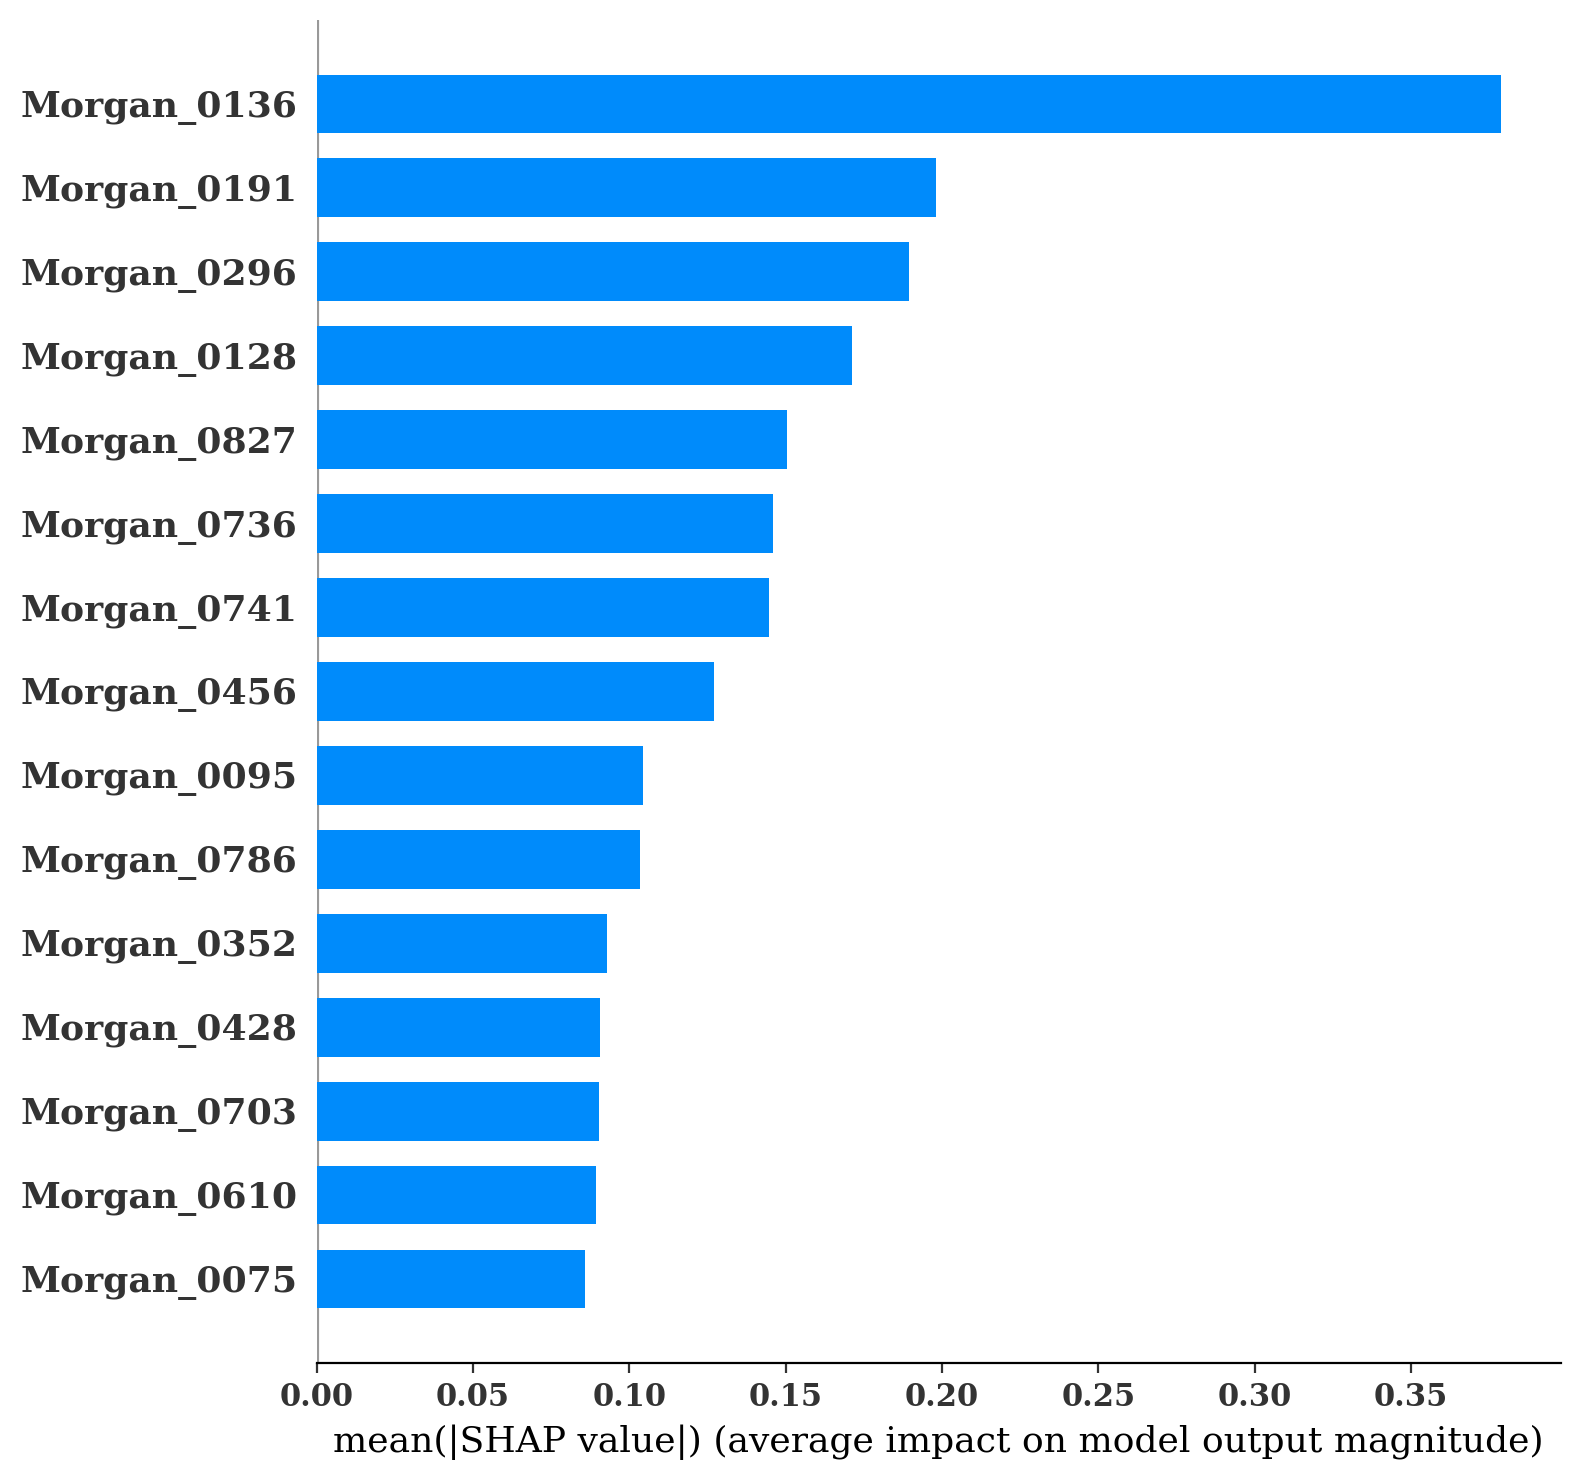

In [9]:
import shap
import matplotlib.pyplot as plt
# max_display=10) 只展示前10个最重要的特征  ，默认20
shap.summary_plot(shap_values, train_X, plot_type="bar", show=False, max_display=15)  #RF时改为(shap_values[1]
# 保存生成的图表到SVG文件
plt.savefig('单个特征重要度图-15.svg', format='svg', bbox_inches="tight")

##### 可以使用SHAP的Explanation对象shap_values2来绘制全局条形图
##### 全局条形图summary_plot 方法2)

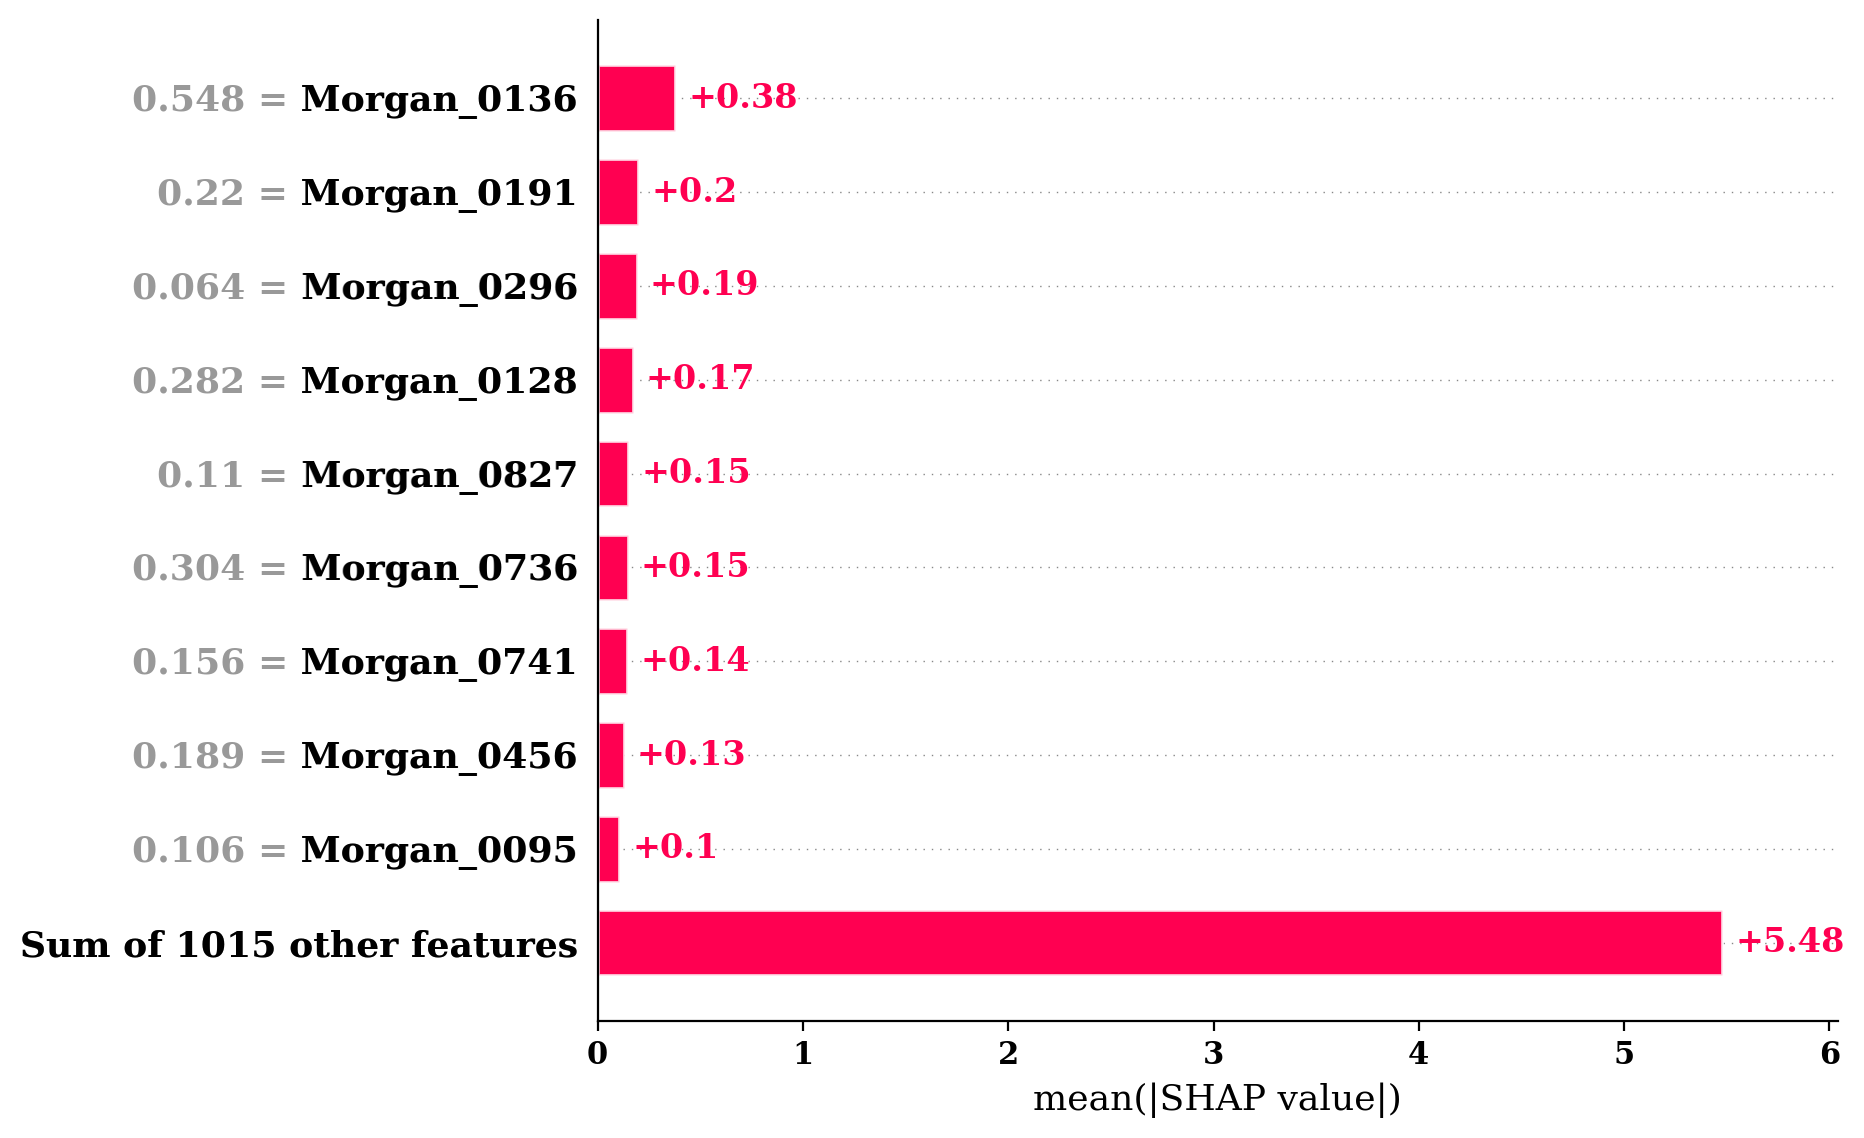

In [31]:
shap.plots.bar(shap_values2,show_data=True,max_display=10)
# Save the plot as a TIFF file
plt.savefig('shap_values_plot.png', format='png')
plt.close()

##### 绘制默认效果的Summary_plot图
##### Y轴：展示了各个特征,每一个特征都有自己的一行，所有的特征都被排列在一起，便于查看和比较。
##### X轴：SHAP值,衡量了每个特征对模型预测的贡献大小。正值表示增加预测结果的可能性，负值表示减小预测结果的可能性。

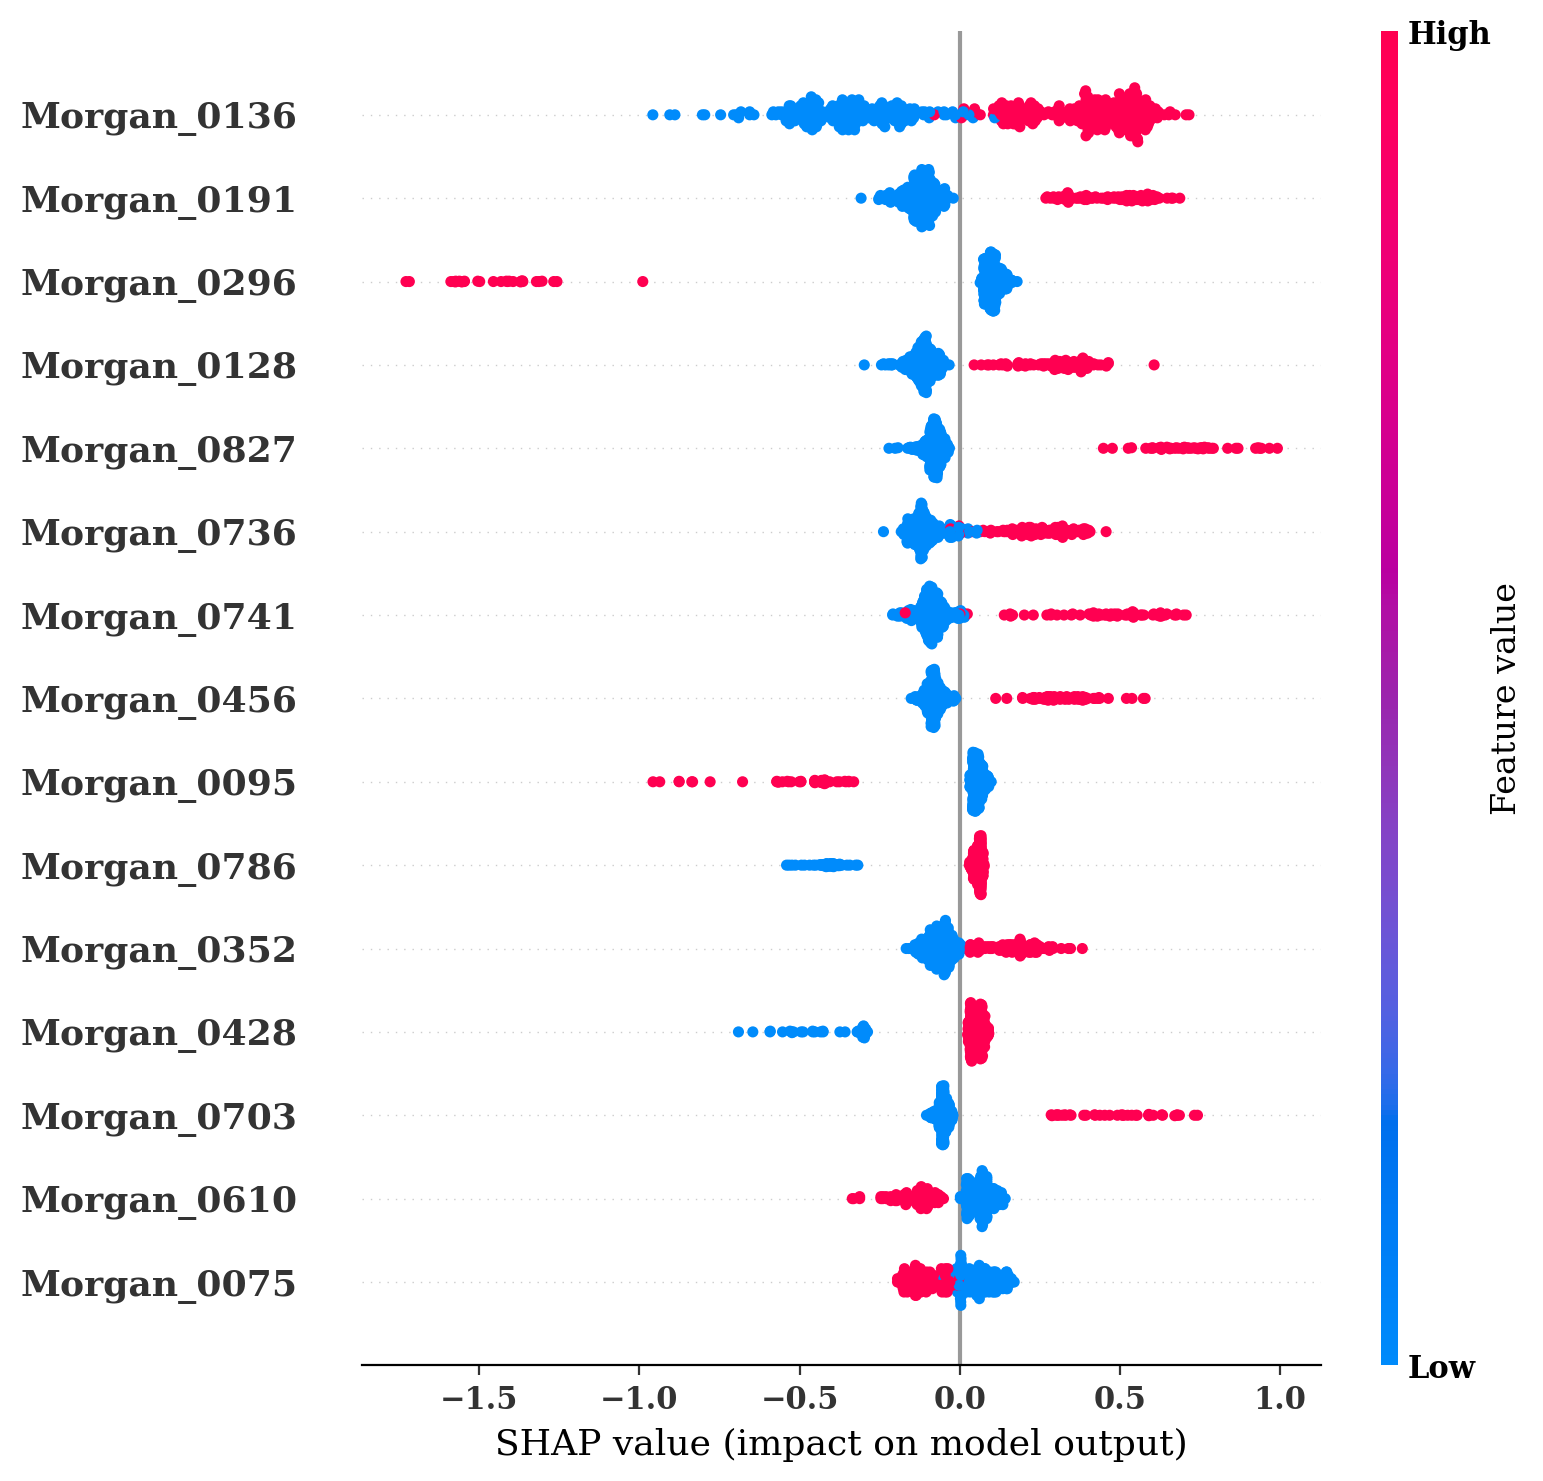

In [10]:
shap.summary_plot(shap_values, train_X, show=False,max_display=15,)
plt.savefig('单个特征重要度蜂群图-15.svg', format='svg',bbox_inches="tight")

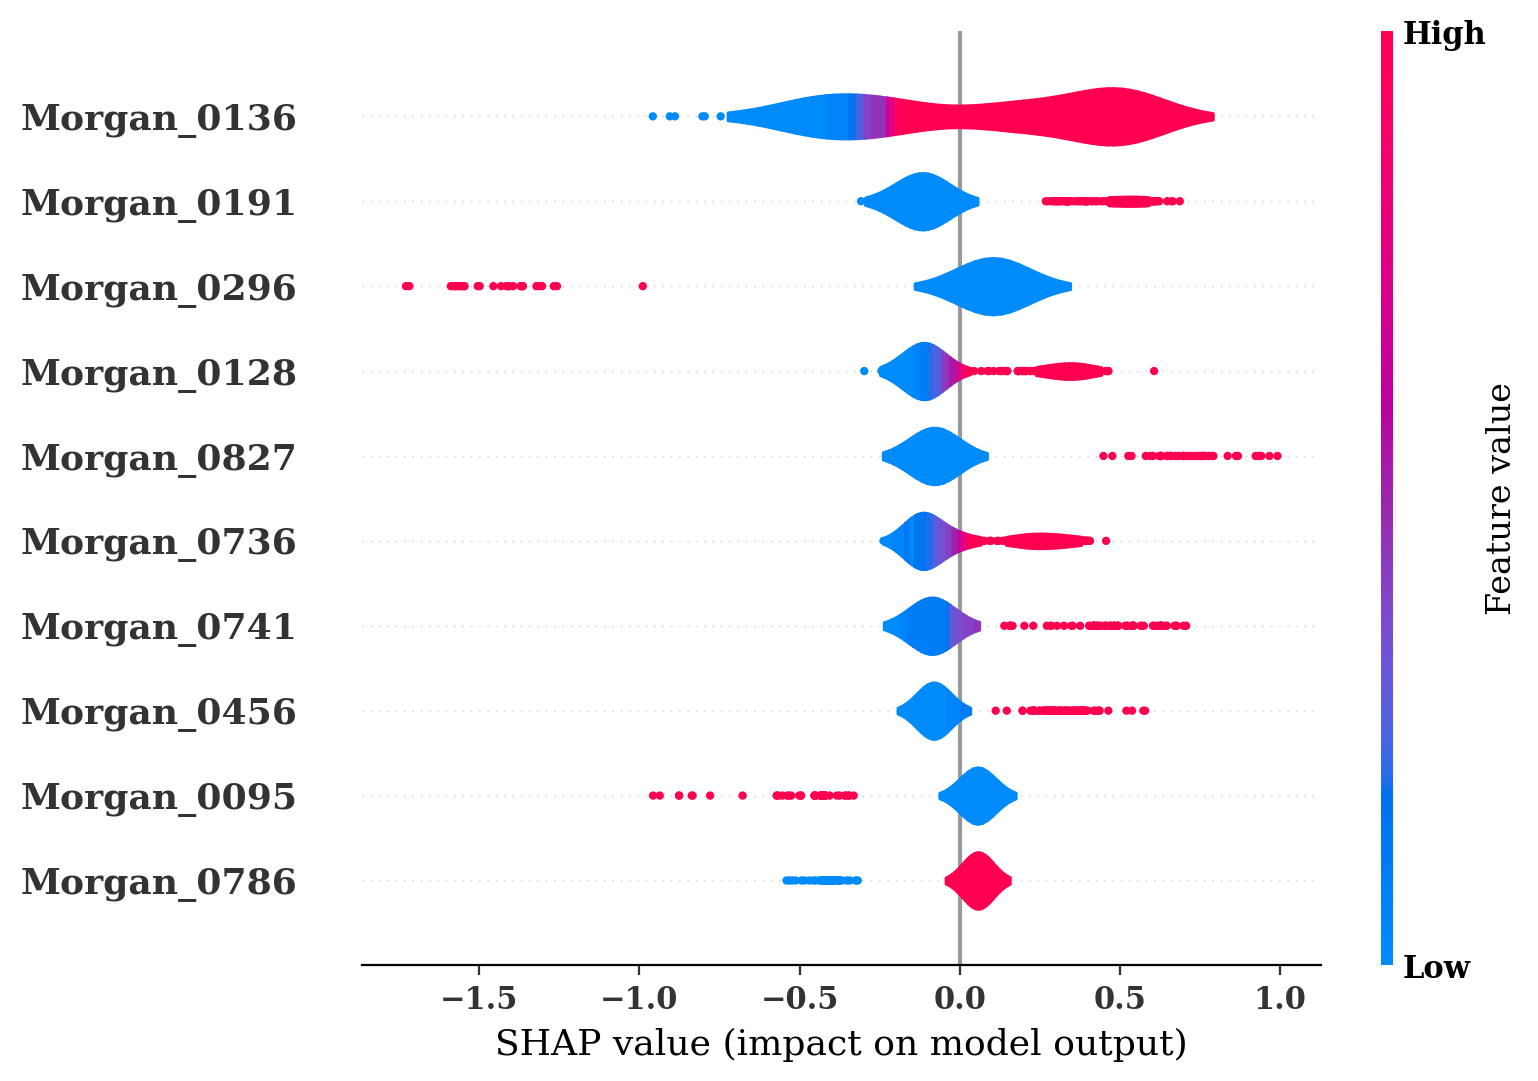

In [27]:
shap.summary_plot(shap_values, train_X, plot_type="violin", show=False,max_display=10)
plt.savefig('单个特征重要度图小提琴图.svg', format='svg',bbox_inches="tight")
#########小提琴图的缺点在于不好解释

##### Heatmap Plot热图显示了一个数据集的整体子结构，其中样本和特征都通过它们的 shap values 进行聚类排序，以便显示出数据的内在结构。
##### 默认使用 shap.utils.hclust_ordering 进行聚类。这对于理解模型在整个数据集上的行为非常有用。
##### 在热图矩阵上方是模型的输出，灰色虚线是基线(.base_value），图右侧的条形图是每个模型输入的全局重要性（默认用shap.order.abs.mean整体重要性来度量）。
##### 热图 x 轴上是样本、y 轴上是模型输入以及色标上是编码的 SHAP 值。

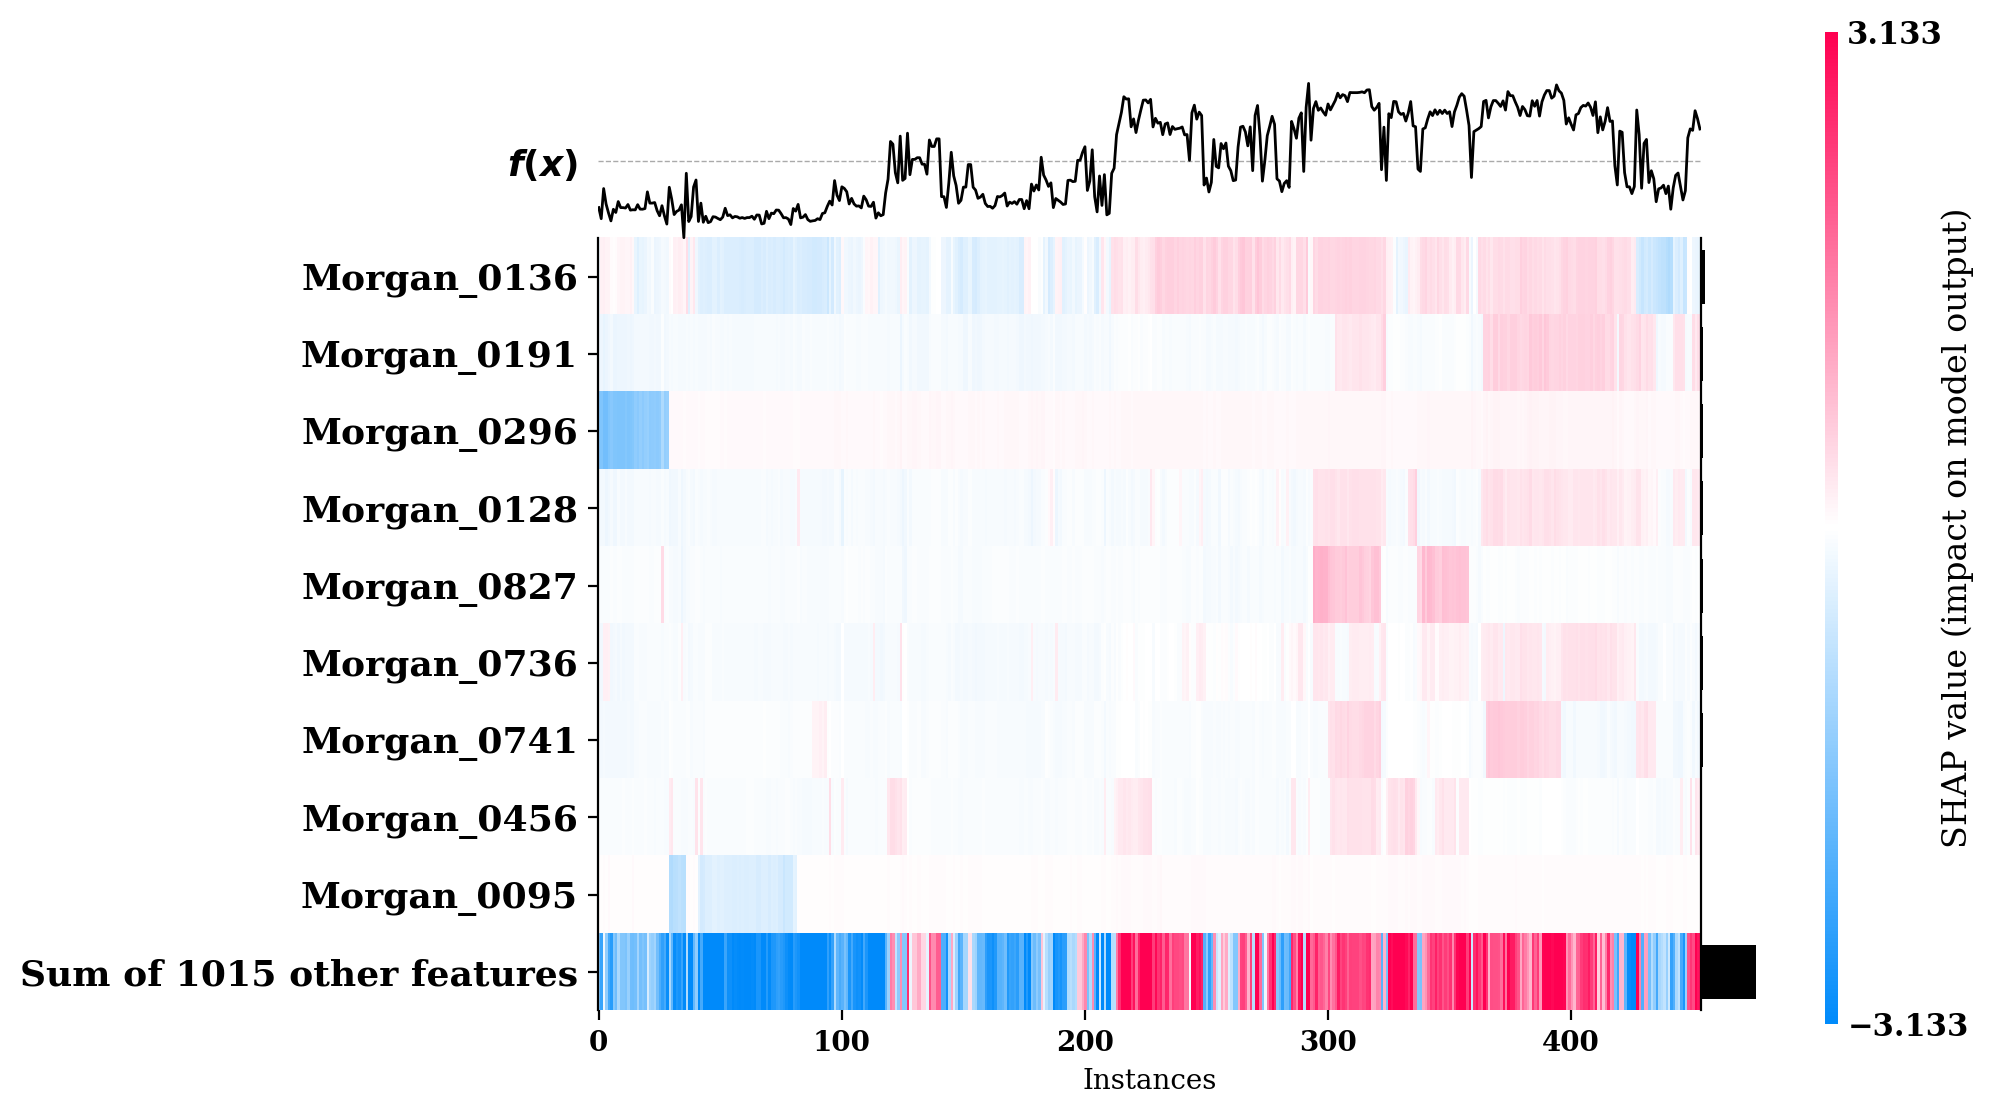

In [32]:
shap.plots.heatmap(shap_values2)

In [ ]:
# 更改特征排序，默认情况下feature_values=shap.Explanation.abs.mean(0)，还可以在所有样本中按特征的最大绝对值进行排序。
shap.plots.heatmap(shap_values2, 
                   feature_values=shap_values2.abs.max(0))

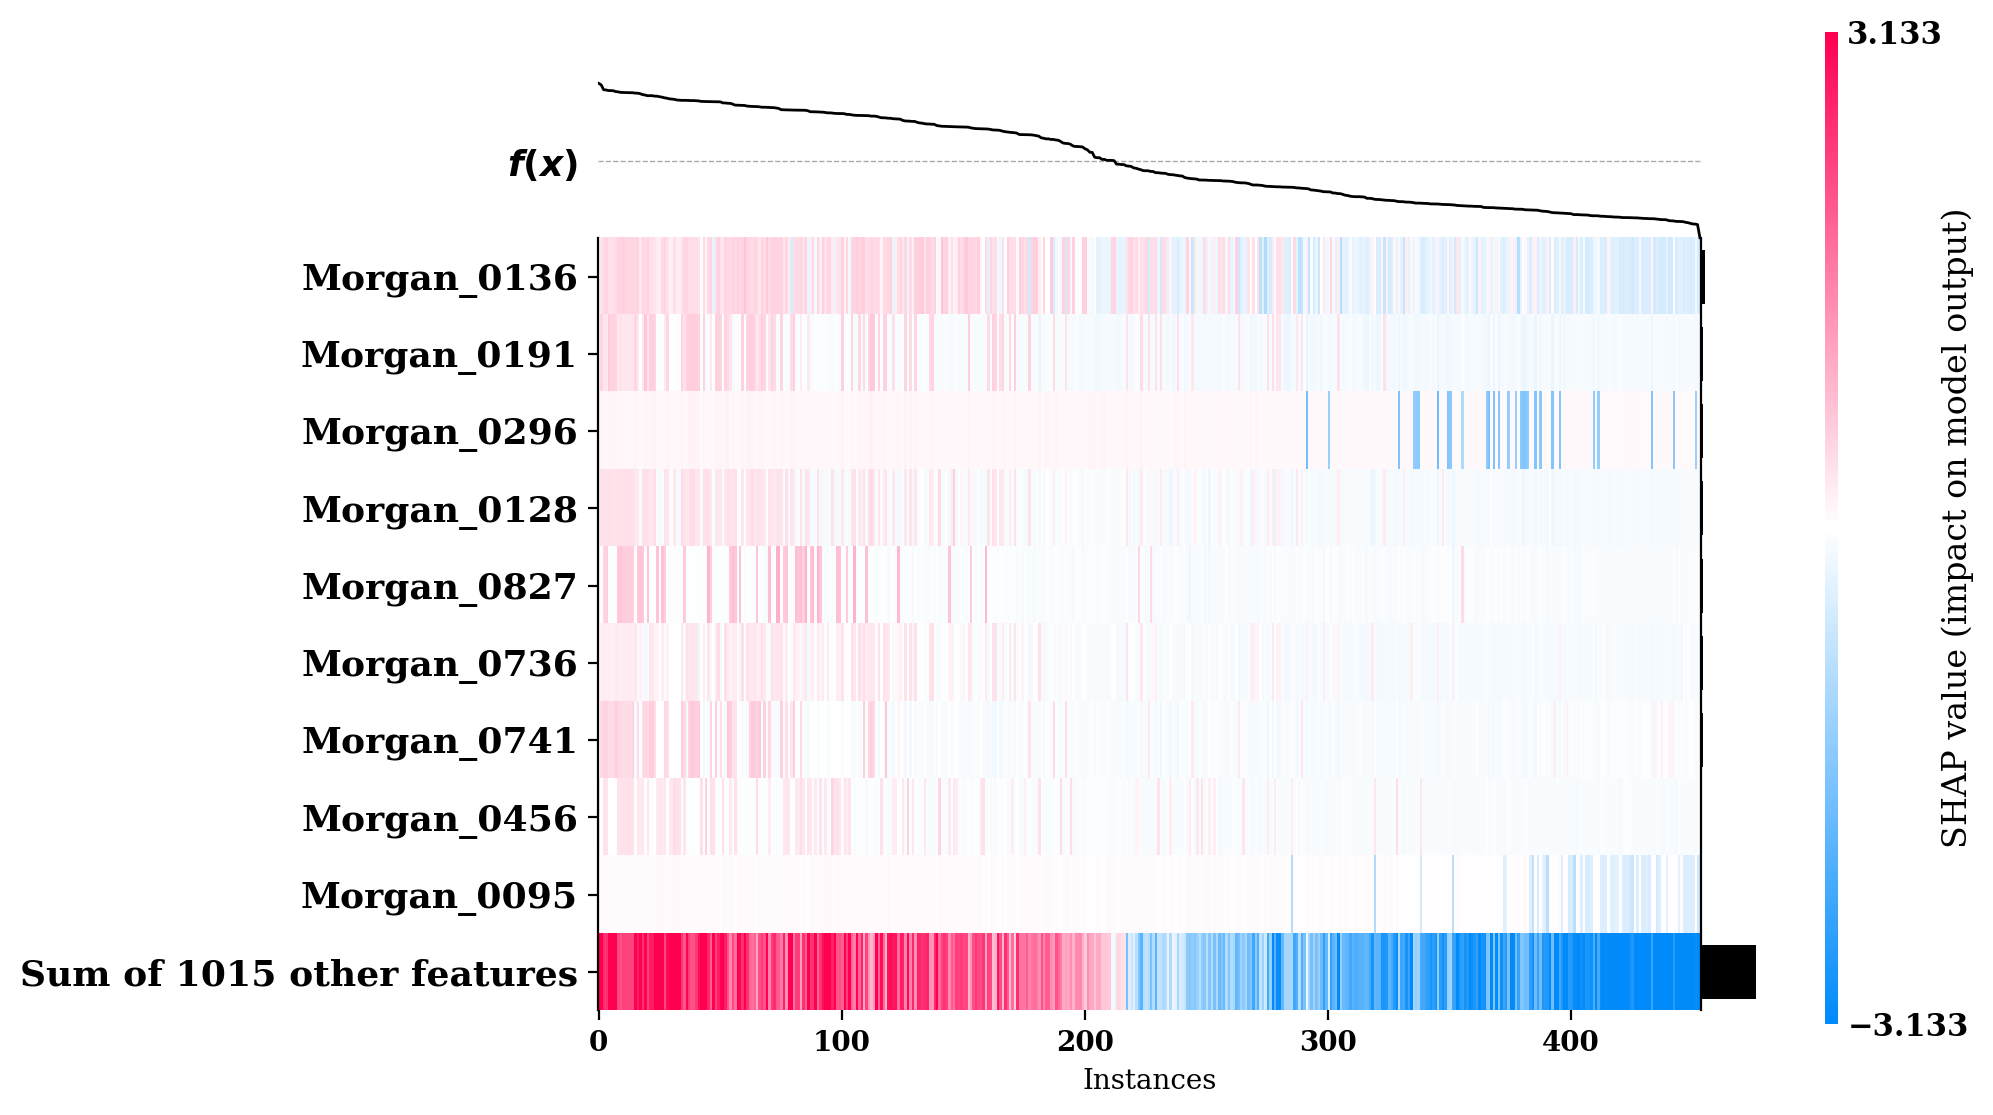

In [34]:
# 更改特征排序。sum(1) 的意思是对 shap_values2 的每一行（每个样本）计算所有特征SHAP值的和。
# 这个和反映了每个样本对模型输出的总贡献，可以用来对样本进行排序，以便在热图中显示。
shap.plots.heatmap(shap_values2, 
                   instance_order=shap_values2.sum(1))

In [ ]:
# Interaction Values 点的水平位置表示该特征对模型预测的影响，
# 其中位于中心（垂直虚线）右侧的点表示该特征将模型预测值推高，位于左侧的点表示该特征将模型预测值推低。
shap_interaction_values = explainer.shap_interaction_values(train_X)
shap.summary_plot(shap_interaction_values,train_X, show=False)
plt.savefig('总体特征重要性.svg',format='svg',bbox_inches="tight")

In [66]:
# SHAP特征重要性-Force Plot
# Force Plot用于展示单个预测的SHAP值，帮助我们理解每个特征是如何影响模型输出的，实现单个预测的解释可视化。
b = shap.plots.force(explainer.expected_value,shap_values[58])     ###  shap_values[0])表示第一个数据
shap.save_html('特征影响图_58.html', b)
b

In [77]:
####   多个样本的可解释性,对测试集中的前100个样本进行可视化解释     shap_values[:100, :]
a = shap.plots.force(explainer.expected_value,shap_values[407])
shap.save_html('特征影响图-5-IT.html', a)
a

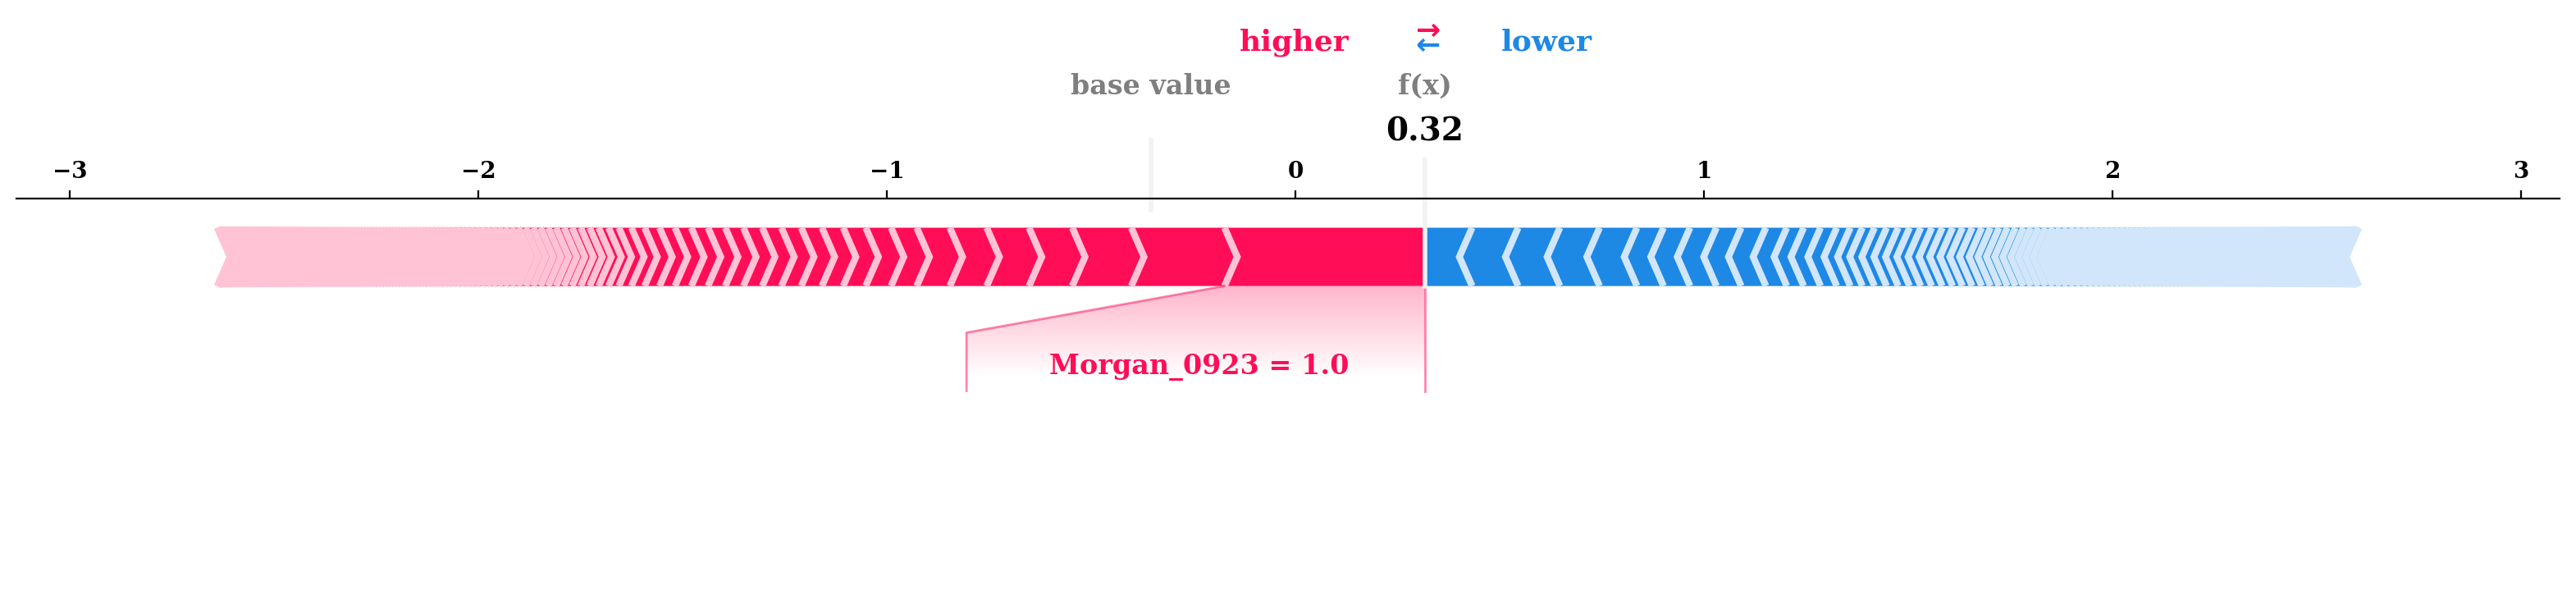

In [79]:
explainer = shap.TreeExplainer(GBT)
# X_train.iloc[0, :]选取测试数据集中的第一行（即第一个实例）
shap_value_single = explainer.shap_values(X = train_X.iloc[408,:]) # ABT-702
#shap_value_single = explainer.shap_values(X = train_X.iloc[60,:]) # GP3269
# 使用force_plot创建一个力量图（force plot），这是一种展示单个预测的解释的可视化形式
# - base_value是模型输出的基准值，即没有任何特征时模型的预期输出。这里使用explainer.expected_value[1]，
#   它代表了对应于目标类别（通常是正类）的基准值
# - shap_values是计算得到的SHAP值，这里使用shap_value_single[1]指的是对应正类的SHAP值
# - features是该实例的特征值，这里使用X_train.iloc[0,:]
shap.force_plot(base_value=explainer.expected_value
                , shap_values=shap_value_single
                , features=train_X.iloc[408,:]
                , matplotlib=True)

# Ensure current figure is set to the SHAP force plot
fig = plt.gcf()

# 调用matplotlib的保存功能，png无法显示
#plt.savefig('./SHAP.png', bbox_inches='tight')
plt.close(fig)  # Close the figure after saving to avoid consuming memory

# 可视化决策过程-分子描述符

In [ ]:
#####   描述符可跑，分子指纹不用跑
shap.decision_plot(expected_value, shap_values, train_X, show=False)
plt.savefig("可视化决策过程.svg", format='svg',bbox_inches="tight")

## 展示某个特征从小变大时对预测结果的shap值

In [ ]:
columns = train_X.columns
columns

In [ ]:
for i in columns:
    shap.dependence_plot(i, shap_values[1],  train_X, interaction_index=None, show=False)
    plt.savefig(i + '特征预测结果的shap值图[1]_点图.svg', format='svg',bbox_inches="tight")

In [ ]:
for i in columns:
    shap.partial_dependence_plot(i, RF.predict, train_X, model_expected_value=True, feature_expected_value=True,show=False)
    plt.savefig(i + '特征预测结果的shap值图[1]_线图.svg',format='svg',bbox_inches="tight")

## 特征间相互影响图

In [ ]:
import itertools
combination_features = list(itertools.combinations(columns, 2))
combination_features
for i in combination_features:
    feat_name1 = i[0]
    feat_name2 = i[1]
    shap.dependence_plot( feat_name1, shap_values[1], train_X, interaction_index=feat_name2, show=False)
    plt.savefig(i[0] + '_'+ i[1] +'相互影响[1]_点图.svg',format='svg',bbox_inches="tight")

## 描述符可视化

#### MolLogP可视化
LogP表示脂水分配系数，该值认为与细胞通透性有一定相关性。rdkit中提供的Descriptors.MolLogP()方法可以粗略计算logP值，
该方法首先做了一个原子分类系统，根据原子及其相连原子的不同而进行分类，再对化学性质相似、logP贡献相似的类别做合并，
最终得到了68种精确的原子类别和4种通配类别，并用SMARTS表示。计算时，对一个分子中所有原子进行分类，再乘以每一类的权重并加和，最终得到LogP值。
该方法在9920个分子的训练集上的r2为0.918，标准差为0.667。此外摩尔折射率（molar refractivity，MR）也可以通过这种方法计算得到。

In [ ]:
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import SimilarityMaps
mol = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')

In [ ]:
from rdkit.Chem import rdMolDescriptors
contribs = rdMolDescriptors._CalcCrippenContribs(mol)
contribs[:3]

In [ ]:
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, [x for x,y in contribs])

# 指纹片段可视化

In [ ]:
#### 生成的这个文件可以查看每个分子的分子指纹有无
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import csv

# 加载数据
data = pd.read_csv('ADK.csv')
canonical_smiles = data['canonical_smiles'].tolist()  # 确保这是正确的列名
molecule_chembl_id = data['molecule_chembl_id'].tolist()  # 正确加载molecule_chembl_id列

# 标准化SMILES并创建分子对象
c_smiles = []
molecules = []
chemble_ids = []

for i, ds in enumerate(canonical_smiles):
    try:
        mol = Chem.MolFromSmiles(ds)
        if mol:  # 确保mol对象被成功创建
            cs = Chem.MolToSmiles(mol)
            c_smiles.append(cs)
            molecules.append(mol)
            chemble_ids.append(molecule_chembl_id[i])  # 同步保存对应的Chembl ID
        else:
            print('Failed to create Mol object:', ds)
    except Exception as e:
        print('Invalid SMILES:', ds, "Error:", e)

# 计算Morgan指纹并保存到CSV文件
with open('molecular_fingerprints-1024-id.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # 写入列标题
    headers = ['ChEMBL_ID', 'SMILES'] + [f'Bit_{i}' for i in range(1024)]
    writer.writerow(headers)

    for chembl_id, mol in zip(chemble_ids, molecules):
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
            # 将指纹转换为0和1的列表
            bit_list = list(fp.ToBitString())
            # 将ChEMBL ID、SMILES和指纹数据写入CSV
            writer.writerow([chembl_id, Chem.MolToSmiles(mol)] + bit_list)

print("Molecular fingerprints have been saved to 'molecular_fingerprints-1024-id.csv'.")

In [16]:
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import Chem
data = pd.read_csv('./train-dataset-ECFPs.csv')
Canonical_SMILES = []
for i in data.canonical_smiles:
    Canonical_SMILES.append(i)

ar1_smiles = Canonical_SMILES
c_smiles = []
for ds in ar1_smiles:
    try:
        cs = Chem.CanonSmiles(ds)
        c_smiles.append(cs)
    except:
        print('Invalid SMILES:', ds)
print()

ms = [Chem.MolFromSmiles(x) for x in c_smiles]
for mol in ms:
    bi = {}
    #RDKfps = Chem.RDKFingerprint(mol,bitInfo=bi)  ###可视化RDKFingerprint指纹
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024, bitInfo=bi)
    print(bi)


{19: ((18, 2),), 33: ((0, 0),), 40: ((21, 2),), 64: ((9, 1), (10, 1), (11, 1), (18, 1)), 75: ((3, 2),), 109: ((5, 2),), 128: ((15, 0),), 136: ((7, 1),), 152: ((3, 1),), 175: ((9, 2), (11, 2)), 178: ((4, 2),), 191: ((16, 1), (13, 2)), 209: ((24, 2),), 222: ((7, 2),), 233: ((27, 1), (29, 1)), 285: ((0, 1),), 343: ((22, 2),), 352: ((6, 1),), 356: ((6, 0), (7, 0), (13, 0), (14, 0), (16, 0), (25, 0)), 378: ((20, 0), (22, 0), (24, 0)), 389: ((10, 2),), 428: ((22, 1), (24, 1)), 437: ((19, 2),), 454: ((26, 2),), 463: ((26, 1), (28, 1)), 464: ((5, 1),), 489: ((23, 1),), 491: ((15, 1),), 511: ((21, 1),), 550: ((1, 2),), 562: ((20, 2),), 577: ((4, 1),), 579: ((20, 1),), 599: ((2, 2),), 656: ((2, 0),), 672: ((25, 1),), 685: ((16, 2),), 703: ((17, 2),), 708: ((14, 1),), 722: ((1, 1),), 726: ((8, 1), (17, 1), (12, 1)), 736: ((8, 2), (12, 2)), 741: ((14, 2),), 772: ((28, 2),), 786: ((23, 2),), 807: ((27, 0), (29, 0)), 842: ((19, 1),), 849: ((5, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (17, 0),

In [41]:
for x in c_smiles:
    print(x)

CC1OC(n2cc(-c3ccccc3)c3c(Nc4cccnc4)ncnc32)C(O)C1O
NCC1OC(n2cc(Br)c3c(N)ncnc32)C(O)C1O
CCC1(c2ccc(CSc3ccc(F)cc3F)cc2)Oc2ccccc2-n2cccc2C1=O
Nc1ncnc2c1c(-c1ccc3c4c(cccc14)CC3)cn2C1OC(CO)C(O)C1O
O=C(CNc1ncnc2c1c(-c1ccccc1)cn2C1OC(CO)C(O)C1O)NC1CC1
CSc1ncnc2c1c(I)cn2C1OC(C)C(O)C1O
CC(C)CNC(=O)CNc1ncnc2c1c(-c1ccccc1)cn2C1OC(C)C(O)C1O
CCCCCc1cc2c(N)ncnc2nc1-c1ccc(N(C)C)cc1
OCC1OC(n2cc(Cl)c3c(-c4ccccc4)ncnc32)C(O)C1O
CC1OC(n2cc(-c3ccccc3)c3c(Nc4ccc(C#N)cc4)ncnc32)C(O)C1O
CN(C)c1ccc(C#Cc2ncnc(N3CCNCC3)c2-c2ccc(Cl)cc2)cc1
Nc1ncnc2nc(-c3ccc(N4CCC5(CC4)COCO5)nc3)cc(-c3cccc(Br)c3)c12
OCC1OC(n2ccc3c(-c4cc5ccccc5o4)ncnc32)C(O)C1O
CC1OC(n2cc(-c3ccccc3)c3c(Nc4ccccc4)ncnc32)C(O)C1O
CSc1ncnc2c1c1ccn(C)c1n2C1OC(CO)C(O)C1O
O=C1c2cccn2-c2ccccc2OC1c1ccc(CSc2cccc(C(F)(F)F)c2)cc1
Nc1ncnc2c1c(-c1ccc3c(c1)OCO3)cn2C1OC(CO)C(O)C1O
CN(Cc1ccccc1)c1c(N)ncnc1C#Cc1ccc(N2CCOCC2)nc1
O=C1C(c2cccc3ccccc23)Oc2cc(F)ccc2N1Cc1ccc(F)cc1
[N-]=[N+]=NCC1OC(n2cc(I)c3c(N)ncnc32)C(O)C1O
CCC1(c2ccc(CSc3ccc(I)cc3Cl)cc2)Oc2ccccc2-n2cccc

{75: ((12, 2), (11, 2)), 80: ((14, 0),), 147: ((0, 0),), 152: ((11, 1),), 178: ((10, 2),), 209: ((4, 2),), 210: ((13, 2),), 222: ((15, 1),), 233: ((17, 1), (19, 1)), 356: ((1, 0), (5, 0), (6, 0), (7, 0)), 378: ((2, 0), (4, 0)), 428: ((2, 1), (4, 1)), 433: ((0, 1),), 435: ((1, 1),), 454: ((18, 2),), 463: ((16, 1), (18, 1)), 464: ((9, 1),), 489: ((3, 1),), 492: ((14, 1),), 548: ((2, 2),), 577: ((10, 1),), 582: ((7, 1),), 610: ((13, 1),), 656: ((12, 0),), 661: ((8, 0),), 672: ((5, 1),), 726: ((1, 2),), 740: ((14, 2),), 777: ((9, 2),), 786: ((3, 2),), 793: ((7, 2),), 807: ((15, 0), (17, 0), (19, 0)), 820: ((16, 2),), 849: ((3, 0), (9, 0)), 897: ((12, 1),), 923: ((6, 2),), 935: ((10, 0),), 947: ((8, 1),), 960: ((6, 1),), 1001: ((5, 2),), 1019: ((11, 0), (13, 0), (16, 0), (18, 0))}


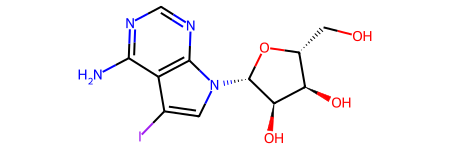

In [85]:
#   5-Iodotubercidin    CHEMBL99203   26nm
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles('Nc1ncnc2c1c(I)cn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O') 
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024, bitInfo=bi) #注意nBits=1024
print(bi)  
mol

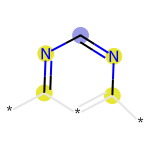

In [89]:
bi[786] 
img = Draw.DrawMorganBit(mol,786 , bi,useSVG=False) 
#img.save("Morgan610.png")
img

{15: ((24, 2),), 64: ((24, 1),), 136: ((8, 1), (22, 1)), 147: ((0, 0),), 151: ((12, 2),), 217: ((18, 2),), 266: ((28, 2),), 323: ((22, 2),), 346: ((11, 2),), 352: ((21, 1),), 356: ((1, 0), (5, 0), (7, 0), (8, 0), (11, 0), (21, 0), (22, 0), (26, 0), (29, 0)), 365: ((5, 2),), 378: ((2, 0), (4, 0), (6, 0), (18, 0), (20, 2)), 379: ((4, 2),), 381: ((15, 2),), 407: ((12, 1),), 417: ((14, 2), (16, 2)), 428: ((2, 1), (4, 1), (18, 1)), 433: ((0, 1),), 435: ((1, 1),), 456: ((13, 1), (17, 1)), 463: ((19, 2),), 485: ((25, 2), (6, 2)), 489: ((3, 1),), 511: ((19, 1),), 523: ((15, 1),), 527: ((11, 1),), 537: ((21, 2),), 548: ((2, 2),), 600: ((5, 1),), 607: ((27, 1),), 635: ((10, 2),), 650: ((8, 2),), 656: ((15, 0),), 726: ((9, 1), (10, 1), (23, 1), (25, 1), (1, 2)), 728: ((27, 0),), 736: ((23, 2),), 766: ((26, 2),), 786: ((3, 2),), 827: ((29, 2),), 831: ((6, 1),), 849: ((3, 0), (9, 0), (10, 0), (19, 0), (20, 0), (23, 0), (24, 0), (25, 0), (28, 0)), 875: ((20, 1), (28, 1)), 896: ((9, 2),), 909: ((26, 

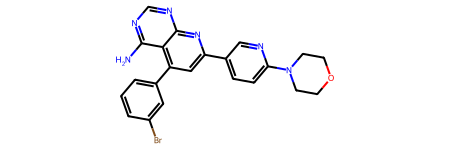

In [31]:
#   ABT-702    CHEMBL66089    1.7nM
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles('Nc1ncnc2nc(-c3ccc(N4CCOCC4)nc3)cc(-c3cccc(Br)c3)c12') 

bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024, bitInfo=bi) #注意nBits=1024
print(bi)  
mol

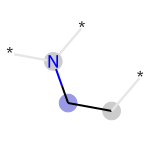

In [61]:
bi[456] 
img = Draw.DrawMorganBit(mol, 456, bi,useSVG=False) 
img.save("Morgan456.png")
img

{33: ((0, 0),), 64: ((9, 1), (10, 1), (11, 1)), 75: ((3, 2),), 90: ((19, 2),), 109: ((5, 2),), 128: ((15, 0),), 136: ((7, 1),), 152: ((3, 1),), 175: ((9, 2), (11, 2)), 178: ((4, 2),), 191: ((16, 1), (13, 2)), 209: ((25, 2),), 222: ((7, 2),), 233: ((28, 1), (30, 1)), 285: ((0, 1),), 343: ((23, 2),), 352: ((6, 1),), 356: ((6, 0), (7, 0), (13, 0), (14, 0), (16, 0), (19, 0), (26, 0)), 378: ((23, 0), (25, 0)), 386: ((18, 2), (21, 2)), 389: ((10, 2),), 428: ((23, 1), (25, 1)), 454: ((27, 2),), 463: ((27, 1), (29, 1)), 464: ((5, 1),), 489: ((24, 1),), 491: ((15, 1),), 500: ((16, 2),), 550: ((1, 2),), 577: ((4, 1),), 599: ((2, 2),), 646: ((19, 1),), 656: ((2, 0),), 672: ((26, 1),), 699: ((20, 1),), 708: ((14, 1),), 722: ((1, 1),), 726: ((8, 1), (17, 1), (18, 1), (21, 1), (12, 1), (22, 1)), 736: ((8, 2), (12, 2)), 741: ((14, 2),), 772: ((29, 2),), 786: ((24, 2),), 807: ((28, 0), (30, 0)), 843: ((17, 2), (22, 2)), 849: ((5, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (17, 0), (18, 0), (21, 0)

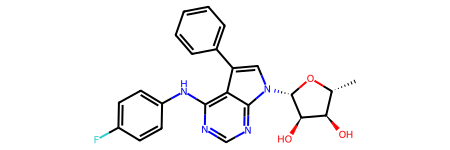

In [37]:
#  GP3269      CHEMBL66277       11nM
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles('C[C@H]1O[C@@H](n2cc(-c3ccccc3)c3c(Nc4ccc(F)cc4)ncnc32)[C@H](O)[C@@H]1O') 
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024, bitInfo=bi) #注意nBits=1024
print(bi) 
mol

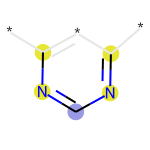

In [65]:
bi[786] 
img = Draw.DrawMorganBit(mol, 786, bi,useSVG=False) 
img.save("Morgan786.png")
img

In [62]:
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles('CCC1(c2ccc(CSc3ccc(F)cc3F)cc2)Oc2ccccc2-n2cccc2C1=O') 
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024, bitInfo=bi) #注意nBits=1024
print(bi)  

{1: ((9, 1),), 9: ((10, 2),), 33: ((0, 0),), 36: ((2, 0),), 64: ((22, 1), (23, 1), (28, 1)), 77: ((27, 1),), 80: ((1, 0), (7, 0)), 95: ((28, 2),), 115: ((1, 2),), 116: ((8, 0),), 148: ((29, 2),), 175: ((22, 2), (23, 2)), 258: ((19, 1),), 271: ((25, 1),), 272: ((31, 1),), 294: ((0, 1),), 310: ((5, 2), (17, 2)), 314: ((32, 1),), 318: ((2, 2),), 327: ((1, 1),), 339: ((31, 2),), 341: ((8, 1),), 347: ((9, 2),), 348: ((20, 2),), 356: ((3, 0), (6, 0), (9, 0), (12, 0), (15, 0), (20, 0), (25, 0), (30, 0), (31, 0)), 386: ((11, 2),), 457: ((21, 2),), 463: ((12, 2), (7, 2)), 477: ((27, 2),), 484: ((4, 2), (18, 2)), 489: ((25, 2),), 556: ((3, 1),), 564: ((26, 1),), 573: ((8, 2),), 604: ((2, 1),), 617: ((19, 2),), 623: ((6, 2), (24, 2)), 646: ((12, 1),), 650: ((32, 0),), 656: ((19, 0),), 668: ((30, 1),), 699: ((13, 1), (16, 1)), 718: ((30, 2),), 726: ((4, 1), (5, 1), (10, 1), (11, 1), (17, 1), (21, 1), (24, 1), (29, 1), (18, 1)), 730: ((6, 1),), 754: ((14, 2),), 762: ((7, 1), (3, 2)), 816: ((15, 1),

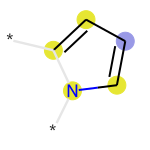

In [63]:
bi[95] 
img = Draw.DrawMorganBit(mol, 95, bi,useSVG=False) 
img.save("Morgan95.png")
img

## 分子指纹映射单个子结构

In [ ]:
mol = Chem.MolFromSmiles('C[C@H]1O[C@@H](n2cc(-c3ccccc3)c3c(Nc4ccc(F)cc4)ncnc32)[C@H](O)[C@@H]1O')

In [ ]:
# 提取Morgan指纹位于索引 690 的Smarts/Smiles
amap = {}
env = Chem.FindAtomEnvironmentOfRadiusN(mol, 2, 8)   # 半径，原子序号
submol=Chem.PathToSubmol(mol, env, atomMap=amap)
print(amap)
print(list(env))

In [ ]:
# 用SMILES表示该子结构-Mrogan690
Chem.MolToSmiles(submol)

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Draw
smi = 'C[C@H]1O[C@@H](n2cc(-c3ccccc3)c3c(Nc4ccc(F)cc4)ncnc32)[C@H](O)[C@@H]1O'
mol = Chem.MolFromSmiles(smi)
patt = Chem.MolFromSmarts('cccc(c)-c') # Morgan-690
mol

In [ ]:
# # 判断是否包含子结构
mol.HasSubstructMatch(patt)

In [ ]:
# # 显示化合物的原子编号
######### 运行这一步将会显示带编号的映射结果
# from rdkit.Chem import Draw
# mol = Chem.MolFromSmiles('C[C@H]1O[C@@H](n2cc(-c3ccccc3)c3c(Nc4ccc(F)cc4)ncnc32)[C@H](O)[C@@H]1O')  ##整个分子
# #为分子加上原子序号
# def add_atom_index(mol):
#     atoms = mol.GetNumAtoms()
#     for i in range( atoms ):
#         mol.GetAtomWithIdx(i).SetProp(
#             'molAtomMapNumber', str(mol.GetAtomWithIdx(i).GetIdx()))
#     return mol
# add_atom_index(mol)
# mol

In [ ]:
# 搜索并返回子结构
hit_at = mol.GetSubstructMatch(patt) # Morgan650所对应的Gen原子编号
print(hit_at)

In [ ]:
# 获取匹配的原子和索引
hit_bond = []
for bond in patt.GetBonds():
    aid1 = hit_at[bond.GetBeginAtomIdx()]
    aid2 = hit_at[bond.GetEndAtomIdx()]
    hit_bond.append(mol.GetBondBetweenAtoms(aid1, aid2).GetIdx())
hit_bond

In [ ]:
# 绘制子结构
from PIL import Image
import io
d = rdMolDraw2D.MolDraw2DCairo(500, 500)
img = rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=list(hit_at), 
                                   highlightBonds=hit_bond)

d.FinishDrawing()
d.WriteDrawingText('GP3269-Morgan736.png') # 保存图像
img = Image.open('GP3269-Morgan736.png')
img

## 高亮展示多个匹配子结构

##### 5-Iodotubercidin

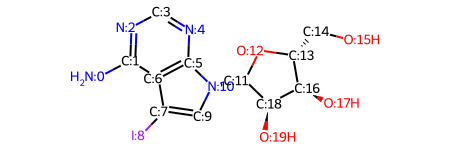

In [90]:
# #   5-Iodotubercidin    CHEMBL99203   26nm
###############展示带序号的整个分子
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles('Nc1ncnc2c1c(I)cn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O')  ##整个分子
#为分子加上原子序号
def add_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for i in range( atoms ):
        mol.GetAtomWithIdx(i).SetProp(
            'molAtomMapNumber', str(mol.GetAtomWithIdx(i).GetIdx()))
    return mol
add_atom_index(mol)
mol

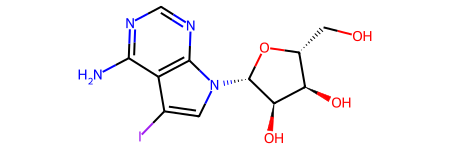

In [91]:
############ 输出没有原子序号的分子结构
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles('Nc1ncnc2c1c(I)cn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O') #整个分子
def add_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for i in range( atoms ):
        mol.GetAtomWithIdx(i).SetProp(
            'molAtomMapNumber', str(mol.GetAtomWithIdx(i).GetIdx()))
    return mol
mol

##### ABT-702

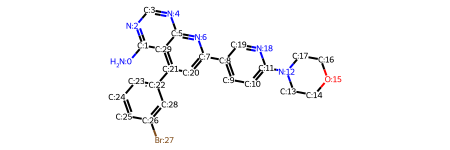

In [15]:
#   ABT-702    CHEMBL66089    1.7nM
###############展示带序号的整个分子
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles('Nc1ncnc2nc(-c3ccc(N4CCOCC4)nc3)cc(-c3cccc(Br)c3)c12')  ##整个分子
#为分子加上原子序号
def add_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for i in range( atoms ):
        mol.GetAtomWithIdx(i).SetProp(
            'molAtomMapNumber', str(mol.GetAtomWithIdx(i).GetIdx()))
    return mol
add_atom_index(mol)
mol

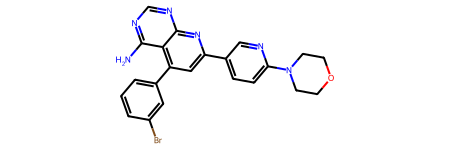

In [16]:
############ 输出没有原子序号的分子结构
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles('Nc1ncnc2nc(-c3ccc(N4CCOCC4)nc3)cc(-c3cccc(Br)c3)c12') #整个分子
def add_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for i in range( atoms ):
        mol.GetAtomWithIdx(i).SetProp(
            'molAtomMapNumber', str(mol.GetAtomWithIdx(i).GetIdx()))
    return mol
mol

##### GP3269

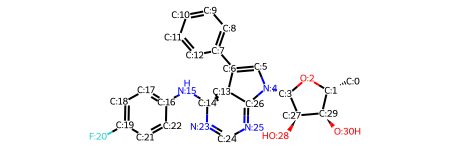

In [38]:
#  GP3269      CHEMBL66277       11nM
###############展示带序号的整个分子
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles('C[C@H]1O[C@@H](n2cc(-c3ccccc3)c3c(Nc4ccc(F)cc4)ncnc32)[C@H](O)[C@@H]1O')  ##整个分子
#为分子加上原子序号
def add_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for i in range( atoms ):
        mol.GetAtomWithIdx(i).SetProp(
            'molAtomMapNumber', str(mol.GetAtomWithIdx(i).GetIdx()))
    return mol
add_atom_index(mol)
mol

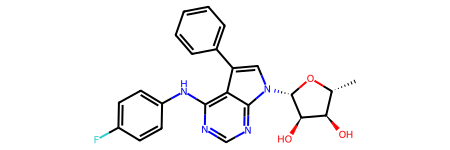

In [39]:
############ 输出没有原子序号的分子结构
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles('C[C@H]1O[C@@H](n2cc(-c3ccccc3)c3c(Nc4ccc(F)cc4)ncnc32)[C@H](O)[C@@H]1O') #整个分子
def add_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for i in range( atoms ):
        mol.GetAtomWithIdx(i).SetProp(
            'molAtomMapNumber', str(mol.GetAtomWithIdx(i).GetIdx()))
    return mol
mol

{15: ((24, 2),), 64: ((24, 1),), 136: ((8, 1), (22, 1)), 147: ((0, 0),), 151: ((12, 2),), 217: ((18, 2),), 266: ((28, 2),), 323: ((22, 2),), 346: ((11, 2),), 352: ((21, 1),), 356: ((1, 0), (5, 0), (7, 0), (8, 0), (11, 0), (21, 0), (22, 0), (26, 0), (29, 0)), 365: ((5, 2),), 378: ((2, 0), (4, 0), (6, 0), (18, 0), (20, 2)), 379: ((4, 2),), 381: ((15, 2),), 407: ((12, 1),), 417: ((14, 2), (16, 2)), 428: ((2, 1), (4, 1), (18, 1)), 433: ((0, 1),), 435: ((1, 1),), 456: ((13, 1), (17, 1)), 463: ((19, 2),), 485: ((25, 2), (6, 2)), 489: ((3, 1),), 511: ((19, 1),), 523: ((15, 1),), 527: ((11, 1),), 537: ((21, 2),), 548: ((2, 2),), 600: ((5, 1),), 607: ((27, 1),), 635: ((10, 2),), 650: ((8, 2),), 656: ((15, 0),), 726: ((9, 1), (10, 1), (23, 1), (25, 1), (1, 2)), 728: ((27, 0),), 736: ((23, 2),), 766: ((26, 2),), 786: ((3, 2),), 827: ((29, 2),), 831: ((6, 1),), 849: ((3, 0), (9, 0), (10, 0), (19, 0), (20, 0), (23, 0), (24, 0), (25, 0), (28, 0)), 875: ((20, 1), (28, 1)), 896: ((9, 2),), 909: ((26, 

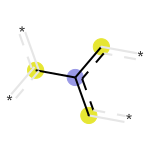

In [17]:
############### 展示想要高亮的片段
from rdkit.Chem import AllChem
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024, bitInfo=bi) #nBits=1024,
print(bi) 
bi[136] #输入想显示分子指纹的位名
img = Draw.DrawMorganBit(mol, 136, bi, useSVG=False)
img

In [76]:
#####   16进制颜色转换为RGB
def hex_to_rgb(hex_color):
    # 去除前缀'#'并转换为三个十六进制的组成部分
    hex_color = hex_color.lstrip('#')
    # 分割成红绿蓝三部分，每部分2个字符，转换为十进制后除以255
    return tuple(int(hex_color[i:i+2], 16)/255.0 for i in (0, 2, 4))
# 定义十六进制颜色代码
hex_colors = ['F9F07A']
# 转换颜色
rgb_colors = [hex_to_rgb(color) for color in hex_colors]
print(rgb_colors)

[(0.9764705882352941, 0.9411764705882353, 0.47843137254901963)]


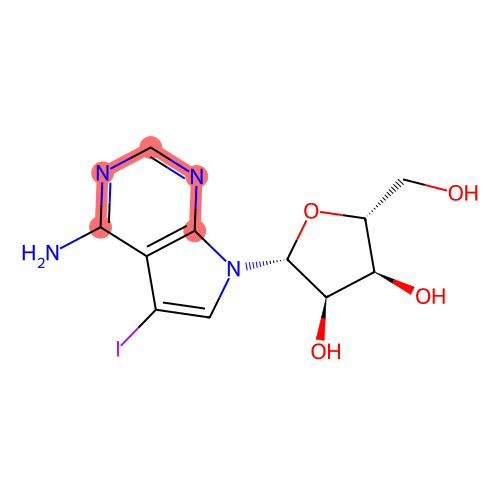

In [13]:
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import display
from PIL import Image
import io
# 定义分子
smiles = 'Nc1ncnc2c1c(I)cn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O'   # 5-ITU
#smiles = 'Nc1ncnc2nc(-c3ccc(N4CCOCC4)nc3)cc(-c3cccc(Br)c3)c12'   #ABT-702
#smiles = 'C[C@H]1O[C@@H](n2cc(-c3ccccc3)c3c(Nc4ccc(F)cc4)ncnc32)[C@H](O)[C@@H]1O'   #GP3269
mol = Chem.MolFromSmiles(smiles)
# 计算摩根指纹并获取位点信息
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024, bitInfo=bi)

# 感兴趣的位点及其颜色
#interest_bits = [786]
#interest_bits = [827,456,136,736]  #ABT-702
#interest_bits = [191,136,128,109]  #GP3269
interest_bits = [786]  #5-IT
#colors = [(0.980, 0.439, 0.439), (0.494, 0.631, 1.0), (0.976, 0.941, 0.478)]  
colors = [(0.980, 0.439, 0.439),(0.980, 0.439, 0.439),(0.980, 0.439, 0.439)] 
# 初始化存储
highlight_atoms = {}
highlight_bonds = {}
for bit, color in zip(interest_bits, colors):
    if bit in bi:
        atom_info = bi[bit]
        for info in atom_info:
            atom_idx, radius = info
            # 特定筛选：例如对于位点191，只选择原子16和半径1
            if (bit == 191 and not (atom_idx == 16 and radius == 1)):
                continue  # 跳过不符合条件的组合
            # 将所有相关原子按颜色分类
            if atom_idx not in highlight_atoms:
                highlight_atoms[atom_idx] = color
            if radius > 0:
                env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
                for bidx in env:
                    bond = mol.GetBondWithIdx(bidx)
                    if bidx not in highlight_bonds:
                        highlight_bonds[bidx] = color
                    highlight_atoms[bond.GetBeginAtomIdx()] = color
                    highlight_atoms[bond.GetEndAtomIdx()] = color
# 创建绘图对象
drawer = rdMolDraw2D.MolDraw2DCairo(500, 500)
drawer.DrawMolecule(mol, 
                    highlightAtoms=highlight_atoms.keys(), 
                    highlightAtomColors=highlight_atoms,
                    highlightBonds=highlight_bonds.keys(),
                    highlightBondColors=highlight_bonds)
drawer.FinishDrawing()
# 显示图像
img_data = drawer.GetDrawingText()
img = Image.open(io.BytesIO(img_data))
#img.save("5-Iodotubercidin.png")
#img.save("GP3269-Morgan_191-136-741.png")
#img.save("ABT-Morgan_827-456-136-736.png")
img

## 高亮不同分子间的不同子结构-例子

In [96]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import rdDepictor
rdDepictor.SetPreferCoordGen(True)
IPythonConsole.drawOptions.minFontSize=20

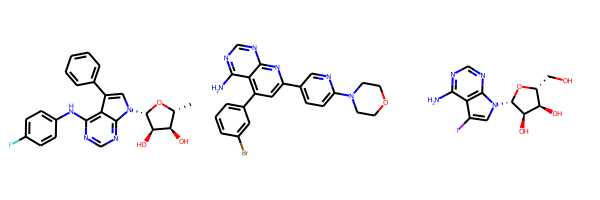

In [94]:
mol1 = Chem.MolFromSmiles('C[C@H]1O[C@@H](n2cc(-c3ccccc3)c3c(Nc4ccc(F)cc4)ncnc32)[C@H](O)[C@@H]1O')
mol2 = Chem.MolFromSmiles('Nc1ncnc2nc(-c3ccc(N4CCOCC4)nc3)cc(-c3cccc(Br)c3)c12')
mol3 = Chem.MolFromSmiles('Nc1ncnc2c1c(I)cn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O')
Draw.MolsToGridImage([mol1, mol2,mol3])

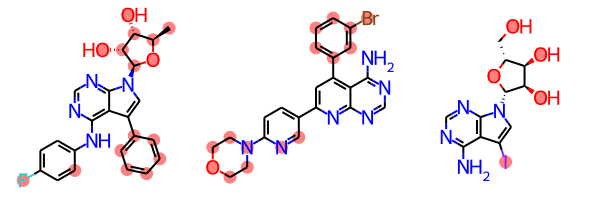

In [97]:
##  原文链接：https://blog.csdn.net/qq_39889473/article/details/125695253
def view_difference(mol1, mol2,mol3):
    mcs = rdFMCS.FindMCS([mol1,mol2,mol3])
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    match1 = mol1.GetSubstructMatch(mcs_mol)
    target_atm1 = []
    for atom in mol1.GetAtoms():
        if atom.GetIdx() not in match1:
            target_atm1.append(atom.GetIdx())
    match2 = mol2.GetSubstructMatch(mcs_mol)
    target_atm2 = []
    for atom in mol2.GetAtoms():
        if atom.GetIdx() not in match2:
            target_atm2.append(atom.GetIdx())
    match3 = mol3.GetSubstructMatch(mcs_mol)
    target_atm3 = []
    for atom in mol3.GetAtoms():
        if atom.GetIdx() not in match3:
            target_atm3.append(atom.GetIdx())    
    return Draw.MolsToGridImage([mol1, mol2,mol3],
                                highlightAtomLists=[target_atm1, target_atm2,target_atm3])      
view_difference(mol1,mol2,mol3)

# LIME

In [ ]:
import lime 
import lime.lime_tabular 
from sklearn import datasets 
from sklearn.ensemble import RandomForestClassifier 

data = pd.read_csv('train_dataset.csv')
x_mor_train = data.iloc[:,2:]   #第三列以后的数据，Python中索引是从0开始的
y_mor_train = data.iloc[:,1:2]  #左开右闭，读取第二列的数据
# x_mor_test = data2.iloc[:,2:]
# y_mor_test = data2.iloc[:,1:2]

train_X = np.array(x_mor_train)
train_y = np.array(y_mor_train).flatten()
target_names = ['inactive','active']

classifier = RandomForestClassifier()
classifier.fit(train_X, train_y) 

feature_names= data.columns.tolist()[2:]

# Create a LIME explainer object 
explainer = lime.lime_tabular.LimeTabularExplainer(train_X, mode="classification", 
                                                   training_labels=train_y,
                                                   feature_names=feature_names, 
                                                   class_names=target_names, 
                                                   discretize_continuous=True) 

# Select an instance to be explained (you can choose any index) 
instance = train_X[0] 

# Generate an explanation for the instance 
explanation = explainer.explain_instance(instance, classifier.predict_proba, num_features=5) 

# Display the explanation 
explanation.show_in_notebook()